In [1]:
import os
import matplotlib.image as img
import numpy as np
import cv2

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [2]:
dirName = '/home/clark/Desktop/wiki_crop'
import matplotlib.image as mimg

listOfFiles = getListOfFiles(dirName)
X_train = []
X_age = []
#X_train = np.empty(shape=[0, 50,50,3])
for image in listOfFiles:
    if image.endswith(".jpg"):
        img = mimg.imread(image)
        if (np.shape(img)[0]!=1):
            resized = cv2.resize(img, (96,96), interpolation = cv2.INTER_AREA)
            #Normalize rgb values to 0~1
            resized = resized/255
            death = int(image.split("/")[-1].split("_")[-1].split(".")[0])
            birth = int(image.split("/")[-1].split("_")[1].split("-")[0])
            if (len(resized.shape)==3 and death-birth>0):
                X_train.append(rgb2gray(resized))
                X_age.append(death-birth)
                #X_train = np.append(X_train, np.asarray([resized]),axis=0)

In [3]:
X_train = np.asarray(X_train)
X_train = X_train.reshape(X_train.shape[0],96,96,1)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')


X_train shape: (48227, 96, 96, 1)
48227 train samples


In [4]:
import random
dat = np.arange(1,13)/2.0

def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs
X_age_binned, cutoff = discretize(X_age, 6)

In [5]:
X_age_binned
X_train[0].shape

(96, 96, 1)

In [4]:
import tensorflow as tf
# define the standalone discriminator model
def get_discriminator():
    in_shape=(96,96,1)
    in_label = tf.keras.Input(shape=(1,))
    li = tf.keras.layers.Embedding(6, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((in_shape[0], in_shape[1], 1))(li)
    in_image = tf.keras.Input(shape=in_shape)
    merge = tf.keras.layers.Concatenate()([in_image, li])
    fe = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same')(merge)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    fe = tf.keras.layers.Flatten()(fe)
    fe = tf.keras.layers.Dropout(0.1)(fe)
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(fe)
    model = tf.keras.Model([in_image, in_label], out_layer)
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def get_generator():
    in_shape=(96,96,1)
    latent_dim = 800
    in_label = tf.keras.Input(shape=(1,))
    li = tf.keras.layers.Embedding(6, 50)(in_label)
    n_nodes = 12*12

    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((12, 12,1))(li)
    in_lat = tf.keras.Input(shape=(latent_dim,))
    n_nodes = 12*12*256
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((12, 12, 256))(gen)
    merge = tf.keras.layers.Concatenate()([gen, li])
    gen = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(merge)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    
    out_layer = tf.keras.layers.Conv2D(1, (12,12), activation='tanh', padding='same')(gen)
    model = tf.keras.Model([in_lat, in_label], out_layer)
    return model
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	print(gen_output.shape)
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = tf.keras.Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [1]:
total_gen_loss =[]
total_disc_loss = []
X_age = np.asarray(X_age)
from numpy.random import randint
from numpy import ones
from numpy.random import randn
from numpy import zeros

    # # select real samples
def generate_real_samples(images,labels, n_samples):
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=6):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y
import timeit
def train(g_model, d_model, gan_model, images, X_age, latent_dim, n_epochs, n_batch=64):
    bat_per_epo = int(images.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        start = timeit.timeit()
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples(images,X_age, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            total_gen_loss.append(g_loss)
            total_disc_loss.append(d_loss2)
            #print(g_loss,d_loss2)
        end = timeit.timeit()
        print("EPOCH",i+1,"FINISHED")
        print('time taken:', end - start)

NameError: name 'np' is not defined

In [5]:
 
# create the discriminator
d_model = get_discriminator()
# create the generator
g_model = get_generator()




In [6]:
pip install pydot


  Using cached https://files.pythonhosted.org/packages/33/d1/b1479a770f66d962f545c2101630ce1d5592d90cb4f083d38862e93d16d2/pydot-1.4.1-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [7]:
tf.keras.utils.plot_model(d_model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


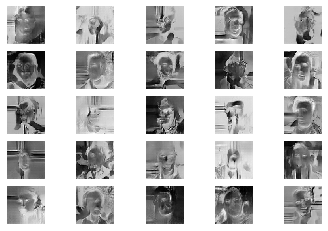

In [29]:
import matplotlib.pyplot as plt

def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0],cmap='gray_r')
	plt.show()
 
latent_points, labels = generate_latent_points(800, 60)
labels = np.asarray([x for _ in range(10) for x in range(6)])
X  = g_model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 5)

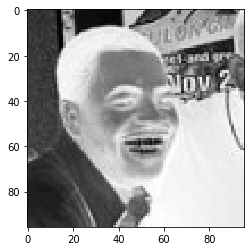

In [45]:
plt.imshow(X_train[6, :, :, 0],cmap='gray_r')

In [27]:
train(g_model, d_model, gan_model, X_train, X_age_binned,800,10,64)
g_model.save('generator1.h5')
d_model.save('discriminator1.h5')
gan_model.save('gan1.h5')


EPOCH 1 FINISHED
time taken: -0.000761449002311565
EPOCH 2 FINISHED
time taken: -0.0001503429957665503
EPOCH 3 FINISHED
time taken: 0.00022346701007336378
EPOCH 4 FINISHED
time taken: -0.00013399501040112227
EPOCH 5 FINISHED
time taken: -0.0003064789780182764
EPOCH 6 FINISHED
time taken: -0.00018643900693859905
EPOCH 7 FINISHED
time taken: -9.669999417383224e-05
EPOCH 8 FINISHED
time taken: -9.881499863695353e-05
EPOCH 9 FINISHED
time taken: -0.0002241809997940436
EPOCH 10 FINISHED
time taken: -0.0002672980190254748


In [28]:
train(g_model, d_model, gan_model, X_train, X_age_binned,800,10,64)
g_model.save('generator2.h5')
d_model.save('discriminator2.h5')
gan_model.save('gan2.h5')
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0],cmap='gray_r')
	plt.show()
 
latent_points, labels = generate_latent_points(200, 60)
labels = np.asarray([x for _ in range(10) for x in range(6)])
X  = g_model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 5)

KeyboardInterrupt: 

In [ ]:
train(g_model, d_model, gan_model, X_train, X_age_binned,800,10,64)
g_model.save('generator3.h5')
d_model.save('discriminator3.h5')
gan_model.save('gan3.h5')
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0],cmap='gray_r')
	plt.show()
 
latent_points, labels = generate_latent_points(200, 60)
labels = np.asarray([x for _ in range(10) for x in range(6)])
X  = g_model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 5)

Text(0.5, 1.0, 'Discriminator Loss')

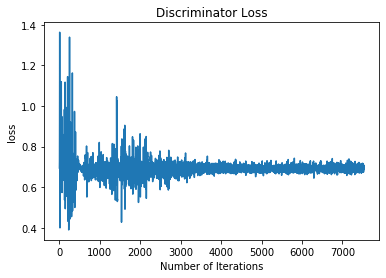

In [38]:
# x axis values 
y = total_disc_loss
# corresponding y axis values 
x = range(0,len(y))
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Number of Iterations') 
# naming the y axis 
plt.ylabel('loss')
plt.title('Discriminator Loss')

Text(0.5, 1.0, 'Generator Loss')

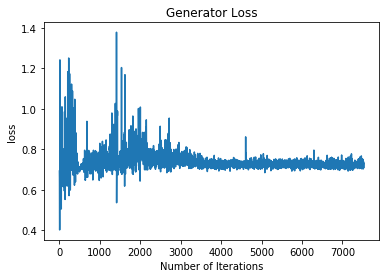

In [39]:
# x axis values 
y = total_gen_loss
# corresponding y axis values 
x = range(0,len(y))
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Number of Iterations') 
# naming the y axis 
plt.ylabel('loss')
plt.title('Generator Loss')

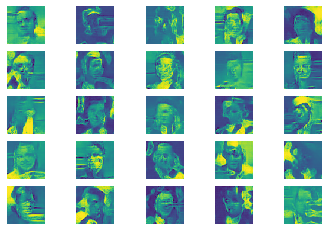

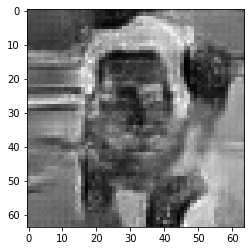

In [63]:
plt.imshow(X[3, :, :, 0],cmap='gray_r')